# Week 7 - HMM Implementation

In [6]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns 
sns.set_style('darkgrid') #set style for graphs

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #filter deprecation warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

#### (1) Load the HR data and plot the observations.

You'll need to figure out an time axis vector for the data (it was recorded starting from midnight at even intervals over 24 hours).

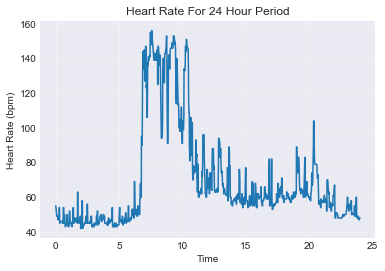

In [2]:
# Plot heart rate throughout day 
hr_data = np.loadtxt('wk7_HR.csv') 
time = np.linspace(0,24,hr_data.shape[0])
plt.plot(time,hr_data)
plt.grid(alpha = 0.3)
plt.title('Heart Rate For 24 Hour Period')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.show()

#### (2) Do you see regions where there might be differences in behavior?

How do you justify your choice?

Yes, there seem to be three different activity levels represented during the 24 hour period. This is indicated by periods of similar heart rates which can be explained by different behaviors throughout the day. When the user was likely asleep, the heart rate was mostly recorded to be below 60 bpm. It seems the user then performed some sort of strenuous activity for the beginning part of the day, as evidenced by a large spike in heart rate. Additionally, there is then a period of time in the afternoon during which the heart rate suggests the user was awake but resting. 

#### (3) Based on when you might expect someone would be asleep, plot the histogram of resting heart rate values.

Given the shape of this distribution, do you think any transformation of the data would be helpful?

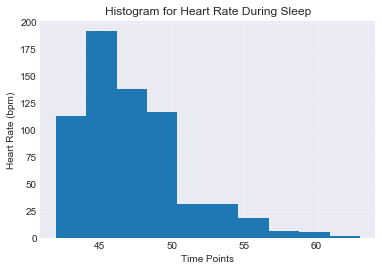

In [3]:
time_sleep = list() # Initiliaze list for time sleep 

wake_up = 6
fall_asleep = 22
t_wu = len(hr_data)*wake_up/24
t_fa = len(hr_data)*fall_asleep/24

# Create new list for anticipated sleep time
for i in range (len(hr_data)):
    if i < t_wu or i > t_fa:
        newsleep = hr_data[i]
        time_sleep.append(newsleep)

# Plot histogram
plt.hist(time_sleep)
plt.xlabel('Time Points')
plt.ylabel('Heart Rate (bpm)')
plt.title('Histogram for Heart Rate During Sleep')
plt.grid(alpha = 0.3)
plt.show()

This histogram resembles a Gaussian distribution, although it is somewhat right-skewed. In order to account for this issue, we could transform the distribution by either taking the log or the square root of the orginal data. Both of these methods can be effective in minimizing the skew of a distribution.

#### (4) One way to deal with noisy data is to use a moving average. Plot the moving average of the data for two different windows. How does this help visualize the data? What is lost using this approach?

**Q**:
How does this help visualize the data? What is lost using this approach?

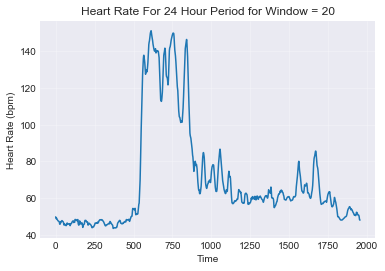

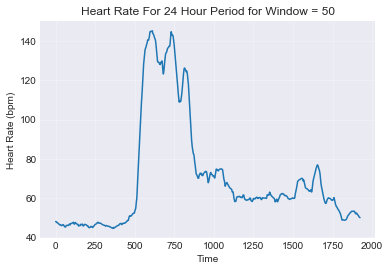

In [4]:
# Define function for moving average
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    return np.convolve(np.squeeze(values), weights, 'valid')

# Plot for window = 50
plt.plot(movingaverage(hr_data, 20))
plt.grid(alpha = 0.3)
plt.title('Heart Rate For 24 Hour Period for Window = 20')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.show()

# Plot for window = 100
plt.plot(movingaverage(hr_data, 50))
plt.grid(alpha = 0.3)
plt.title('Heart Rate For 24 Hour Period for Window = 50')
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.show()

Plotting the moving average of the data makes the trends in the data much easier to visualize by removing or smoothing out noise. However, one disadvantage of using the moving average is that some of the variable's timeliness is lost, because the calculation relies on historical data.

#### (5) We're going to fit an HMM model to this data with three underlying states. This involves three sets of parameters about the model—describe each briefly.

These three sets of parameters would be the initial, transmission, and emission probabilities. The initial probability is the likelihood of the data being in a specific state when the observations begin. The transmission probability is the likelihood of moving from one specific state to another specific state. Finally, the emission probability parameter is a sequence of likelihoods that express the probability of an observation being generated during a particular state. 

#### (6) Fit an HMM model with Gaussian emissions to the data. Use any transformations as necessary.

How does the model respond to rapid state changes? Overlay the raw measurements and HMM state over time.

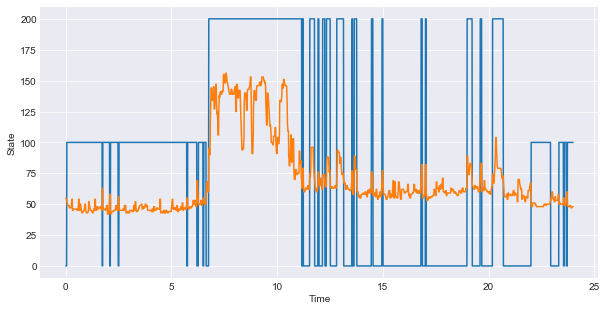

In [7]:
import hmmlearn.hmm as HMM
hmm = HMM.GaussianHMM

# Make an HMM instance and execute fit
modelPred = hmm(n_components=3, n_iter=10000, tol=0.00001)
# Use EM to fit the parameters of the model
reshape_data = hr_data.reshape(-1,1)
modelPred.fit(reshape_data);

# Predict the optimal sequence of internal hidden state
hidden_states = modelPred.predict(reshape_data)

plt.figure(5, figsize=(10,5))
plt.plot(time,hidden_states*100)
plt.plot(time, hr_data)
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

When we overlay the raw measurements and the HMM state, we see that the model is fairly responsive to rapid state changes. For example, the very brief spikes in heart rate in the early hours of the morning are reported as the user being awake for this short time. 

#### (7) From the HMM model determine, with a confidence interval, when the patient woke up in the morning. 
Compare this prediction to the data you obtain with the moving average.

Hint: `model.predict_proba(X)` can give you the probability of being in each state at each time point.

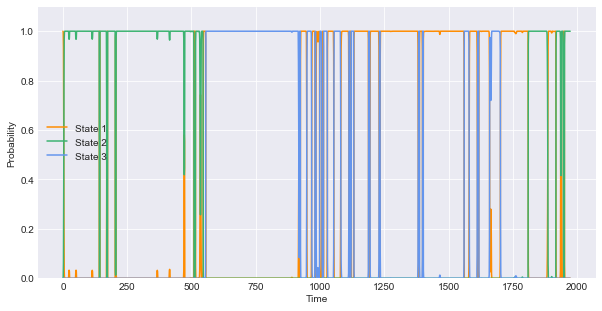

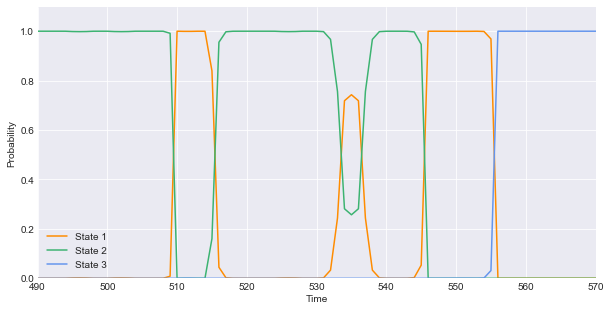

In [12]:
# Obtain probability of being in each state at each time points
stateP = modelPred.predict_proba(reshape_data)

# Plot probabilities
plt.figure(6, figsize=(10,5))
plt.plot(stateP[:,0], label = 'State 1', c = 'darkorange')
plt.plot(stateP[:,1], label = 'State 2', c = 'mediumseagreen')
plt.plot(stateP[:,2], label = 'State 3', c = 'cornflowerblue')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.ylim(0, 1.1);
plt.legend()
plt.show()

# Zoom in on when user wakes up in the morning
plt.figure(7, figsize=(10,5))
plt.plot(stateP[:,0], label = 'State 1', c = 'darkorange')
plt.plot(stateP[:,1], label = 'State 2', c = 'mediumseagreen')
plt.plot(stateP[:,2], label = 'State 3', c = 'cornflowerblue')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.xlim(490, 570);
plt.ylim(0, 1.1);
plt.legend()
plt.show()

From looking closely at the data for this range, it seems that the user woke up at time point 525 with a confidence interval from 510 to 560. The moving average graph seems to indicate a similar time, but it is difficult to determine a confidence interval from this plot. 

#### (8) Say you know there was only one strenuous activity during the day—how might you change the model to fit reality better?

Make this change and show how the results change in a plot.

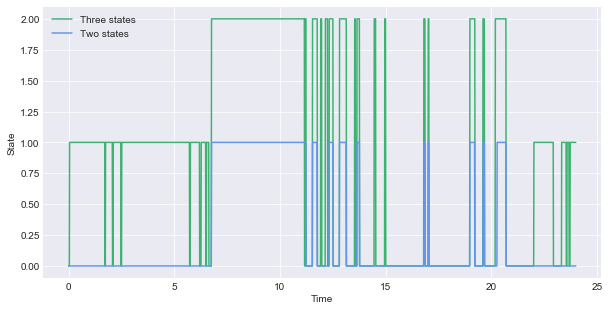

In [15]:
# Make an HMM instance and execute fit
modelPred2 = hmm(n_components=2, n_iter=10000, tol=0.00001)
# Use EM to fit the parameters of the model
modelPred2.fit(reshape_data);

# Predict the optimal sequence of internal hidden state
hidden_states2 = modelPred2.predict(reshape_data)

plt.figure(5, figsize=(10,5))
plt.plot(time,hidden_states,label = 'Three states', c = 'mediumseagreen')
plt.plot(time,hidden_states2, label = 'Two states', c = 'cornflowerblue')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

If we knew that there was only one strenuous activity during the day, we could change the total number of states from three to two. The results of this change are shown on the graph above.

#### (9) Describe one form of other information you could use from a smart watch to make a more accurate determination of the user's state.

How would you use that in your model?

In order to make a more accurate determination of the user's state, we could use the data collected from a smart watch's accelerometer, which measures the intensity of a user's movement. To incorporate this information into the model, we could compare the HMM prediction of the user's state and confirm that it is true using the accelerometer data. For example, if the user's heart rate was detected to be very high, but they were not in motion, it could be assumed that the increase in heart rate was due to nervousness or medical factors rather than due to physical activity. This would make the model's determination of the user's state more accurate overall.